In [1]:
import pandas as pd
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
from pyarrow import csv
import seaborn as sns
import numpy as np

# load the parquet file
df = pq.read_table('data/traffic_data.parquet').to_pandas()

# load latlon data
latlon = pd.read_csv('data/latlon.csv')

pop = pd.read_csv('data/population.csv')
# change types to int
pop['year'] = pop['year'].astype(int)
pop['population'] = pop['population'].astype(int)
pop = pop[::-1]
# reverse just the index
pop = pop.reset_index(drop=True)
pop['growth_rate'] = 1
for i in range(len(pop)):
    if i > 0:
        pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]

# function that takes in a tuple and returns a list
def tuple_to_list(tup):
    return [tup[0], tup[1]]

# function that takes in a tuple stored as string and returns a tuple
def string_to_tuple(tup_str):
    # remove the parentheses and split by comma
    tup_str = tup_str[1:-1]
    return tuple(map(float, tup_str.split(',')))

latlon["latlon"] = latlon["latlon"].apply(lambda x: string_to_tuple(x))
latlon["latlon"] = latlon["latlon"].apply(lambda x: tuple_to_list(x))

df = df.reset_index()

/var/folders/zw/m7v4kfys76l4s15t_m68fgkr0000gn/T/ipykernel_84724/1556626926.py:24: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pop['growth_rate'][i] = pop['population'][i] / pop['population'][i-1]
/var/folders/zw/m7v4kfys76l4s15t_m68fgkr00

/var/folders/zw/m7v4kfys76l4s15t_m68fgkr0000gn/T/ipykernel_84724/2333282766.py:41: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=plot_data, x='holiday_period', y='total_traffic', palette='pastel')


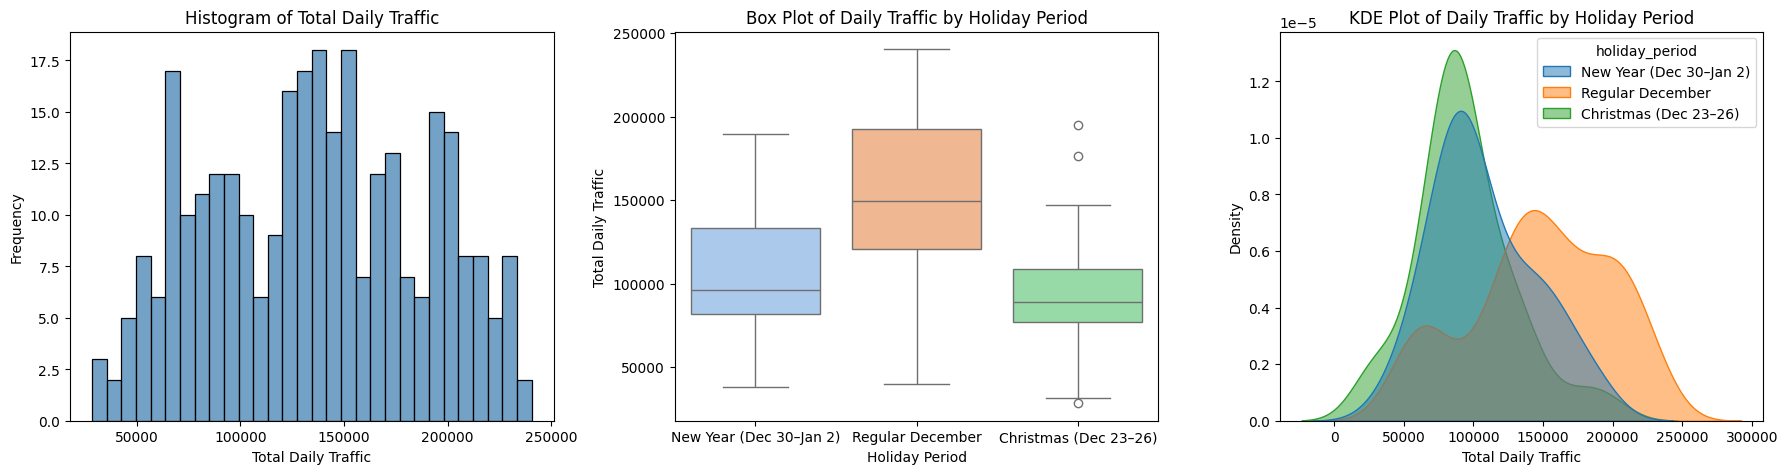

In [3]:
# Prepare datetime and total_traffic
df['datetime'] = pd.to_datetime(df['datetime'])
df['date'] = df['datetime'].dt.date
df['month'] = df['datetime'].dt.month
df['day'] = df['datetime'].dt.day
df['total_traffic'] = df[[col for col in df.columns if '+' in col]].sum(axis=1)

# Tag holiday periods
def classify_day(row):
    if (row['month'] == 12 and 23 <= row['day'] <= 26):
        return 'Christmas (Dec 23–26)'
    elif (row['month'] == 12 and row['day'] >= 30) or (row['month'] == 1 and row['day'] <= 2):
        return "New Year (Dec 30–Jan 2)"
    elif row['month'] == 12:
        return "Regular December"
    else:
        return "Other"

df['holiday_period'] = df.apply(classify_day, axis=1)

# Aggregate total traffic by date and holiday_period
daily_traffic = df.groupby(['date', 'holiday_period'])['total_traffic'].sum().reset_index()

# Filter for relevant periods
plot_data = daily_traffic[daily_traffic['holiday_period'].isin([
    'Christmas (Dec 23–26)', 'New Year (Dec 30–Jan 2)', 'Regular December'
])]

# Plotting
plt.figure(figsize=(18, 5))

# 1. Histogram - Overall
plt.subplot(1, 3, 1)
sns.histplot(plot_data['total_traffic'], bins=30, kde=False, color='steelblue')
plt.title('Histogram of Total Daily Traffic')
plt.xlabel('Total Daily Traffic')
plt.ylabel('Frequency')

# 2. Box Plot - by holiday period
plt.subplot(1, 3, 2)
sns.boxplot(data=plot_data, x='holiday_period', y='total_traffic', palette='pastel')
plt.title('Box Plot of Daily Traffic by Holiday Period')
plt.xlabel('Holiday Period')
plt.ylabel('Total Daily Traffic')

# 3. KDE Plot - by holiday period
plt.subplot(1, 3, 3)
sns.kdeplot(data=plot_data, x='total_traffic', hue='holiday_period', fill=True, common_norm=False, alpha=0.5)
plt.title('KDE Plot of Daily Traffic by Holiday Period')
plt.xlabel('Total Daily Traffic')
plt.ylabel('Density')

plt.tight_layout()
plt.show()

In [ ]:
vehicle_columns = [col for col in df.columns if '+' in col or '-' in col or 'T' in col]
for col in vehicle_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df["total_traffic"] = df[vehicle_columns].sum(axis=1, skipna=True)

# Extract hour of day
df["hour"] = df["datetime"].dt.hour

# Bucket rainfall into categories
def categorize_rain(rain):
    if rain == 0:
        return "No Rain"
    elif rain <= 0.5:
        return "Light Rain"
    elif rain <= 2:
        return "Moderate Rain"
    else:
        return "Heavy Rain"

df["rainfall_category"] = df["rain (mm)"].apply(categorize_rain)

# Group by hour and rain category
traffic_by_hour_rain = (
    df.groupby(["hour", "rainfall_category"])["total_traffic"]
    .mean()
    .reset_index()
)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=traffic_by_hour_rain, x="hour", y="total_traffic", hue="rainfall_category", marker="o")
plt.title("Hourly Traffic Fluctuations by Rainfall Category")
plt.xlabel("Hour of Day")
plt.ylabel("Average Vehicle Count")
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title="Rainfall")
plt.tight_layout()
plt.show()

In [ ]:
# Step 1: Detect vehicle count columns
vehicle_columns = [col for col in df.columns if '+' in col or '-' in col or 'T' in col]

# Step 2: Convert vehicle count columns to numeric
for col in vehicle_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Step 3: Calculate total vehicle count per row (all stations)
df["total_traffic"] = df[vehicle_columns].sum(axis=1, skipna=True)

# Step 4: Drop rows with missing weather code or total traffic
df = df.dropna(subset=["total_traffic", "weather_code (wmo code)"])

# Step 5: Map weather codes to readable names
wmo_mapping = {
    0: "Clear",
    1: "Mainly clear",
    2: "Partly cloudy",
    3: "Overcast",
    45: "Fog",
    48: "Depositing rime fog",
    51: "Drizzle: Light",
    53: "Drizzle: Moderate",
    55: "Drizzle: Dense",
    56: "Freezing drizzle: Light",
    57: "Freezing drizzle: Dense",
    61: "Rain: Slight",
    63: "Rain: Moderate",
    65: "Rain: Heavy",
    66: "Freezing rain: Light",
    67: "Freezing rain: Heavy",
    71: "Snow fall: Slight",
    73: "Snow fall: Moderate",
    75: "Snow fall: Heavy",
    77: "Snow grains",
    80: "Rain showers: Slight",
    81: "Rain showers: Moderate",
    82: "Rain showers: Violent",
    85: "Snow showers: Slight",
    86: "Snow showers: Heavy",
    95: "Thunderstorm: Slight/Moderate",
    96: "Thunderstorm with hail: Slight",
    99: "Thunderstorm with hail: Heavy"
}

df["weather_desc"] = df["weather_code (wmo code)"].map(wmo_mapping)

# Step 6: Group and aggregate total traffic per weather condition
weather_traffic = df.groupby("weather_desc")["total_traffic"].mean().sort_values(ascending=False)

# Step 7: Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=weather_traffic.values, y=weather_traffic.index, palette="viridis")
plt.xlabel("Average Vehicle Count")
plt.ylabel("Weather Condition")
plt.title("Average Traffic Volume by Weather Condition")
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

In [ ]:
# Detect vehicle count columns
vehicle_columns = [col for col in df.columns if '+' in col or '-' in col or 'T' in col]
for col in vehicle_columns:
    df[col] = pd.to_numeric(df[col], errors='coerce')
df['total_vehicles'] = df[vehicle_columns].sum(axis=1, skipna=True)

# Aggregate to daily totals
df['date'] = pd.to_datetime(df['datetime']).dt.date
df['isHoliday'] = df['isHoliday'].astype(bool)  # Ensure boolean
daily = df.groupby(['date', 'isHoliday'])['total_vehicles'].sum().reset_index()
daily['date'] = pd.to_datetime(daily['date'])
daily['year'] = daily['date'].dt.year
daily['day'] = daily['date'].dt.day
daily['month'] = daily['date'].dt.month

# --- FILTER FOR DECEMBER ONLY ---
daily_december = daily[daily['month'] == 12].copy()

# --- PIVOT FOR HEATMAP ---
pivot = daily_december.pivot(index='year', columns='day', values='total_vehicles')
pivot = pivot.astype(float).replace({pd.NA: np.nan})

# --- PLOT HEATMAP ---
plt.figure(figsize=(15, 6))
ax = sns.heatmap(pivot, cmap='YlOrRd', cbar_kws={'label': 'Total Vehicles'}, linewidths=0.1, linecolor='gray')

plt.title('Pixel-Based Heatmap of Daily Vehicle Counts for December\n(Holidays marked with vertical lines)')
plt.xlabel('Day of Year')
plt.ylabel('Year')

# --- ADD VERTICAL LINES FOR DEC 24, 25, 26, 31 ---
for year in pivot.index:
    # Find the correct day-of-year for Dec 24, 25, 26, 31
    is_leap = pd.Timestamp(year=year, month=12, day=31).is_leap_year
    base = 366 if is_leap else 365
    dec_days = [24, 25, 26, 31]
    for d in dec_days:
        doy = pd.Timestamp(year=year, month=12, day=d).dayofyear
        # Draw a vertical line at this day-of-year (align with heatmap grid)
        plt.axvline(doy - 334 - 0.5, color='black', linestyle='--', linewidth=1)  # -334 to align Dec 1 to 1

plt.tight_layout()
plt.show()